# Retrieving Table Data

## Aside: Introduction

**Note:** These **Asides** are scattered throughout the Intro to RSP notebooks. They're roughly what I'd say while presenting, but hide them during the sessions so people don't feel like they need to read them.

The end products of the LSST Science Pipeline are a series of measurements for each detected source in the survey. These measurements are collated within a series of tables, which can be queried using the Astronomical Data Query Language (ADQL). ADQL is based on the Structured Query Language (SQL), which is used widely across many areas (academia, business, IT,...). If you've used the SDSS CasJobs, then you'll have probably written some SQL queries, and you may have written ADQL queries if you've searched the GAIA data archive. Other astronomical surveys, such as PanSTARRS and ZTF are also queryable using ADQL/SQL, so you may be familiar with ADQL/SQL from querying them.

With SDSS CasJobs (and possibly the others mentioned above - I'm less familiar with them), one had to write an SQL query which was then executed on the data servers, but then one had to download the resulting tables to your local machine to perform one's analysis. This worked really well if you could write an SQL query that pretty much delivered your final sample. It worked less well if, say, your local analysis identified an interesting subsample which you then wanted to get more information on. This last step would require you to upload your subsample to the server and do another SQL query that referred to that subsample.

The RSP, by contrast, allows one to do all one's analysis on the data servers. This avoids ever having to download-then-reupload samples, as everything remains on the servers. It also means one needs to be less of an ADQL/SQL wizard to hone-in on your final sample; while you *can* do more advanced queries that do things like JOINing multiple tables, there is less of a need to do so since you can just query one table, get the results, then pass those to a second query that interrogates a different table. While the latter method may be less efficient and somewhat less elegant, I expect people who are new to ADQL/SQL will find it more approachable.

**In this first "Intro the RSP" session** we'll look at how one can find out what tables are available to query, then go on to do some basic queries. By the end of this session, we'll have retrieved a lightcurve for an object whose sky coordinates we knew in advance.

**Note:** Most of what's here is a re-writing of what's available in the DP0 Tutorials, notably Tutorial Notebooks 01 and 07b.

## As per usual, start with importing the required modules...

In [1]:
from lsst.rsp import get_tap_service, retrieve_query

import pandas as pd #This is only so I can set the maximum column width.
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set the maximum column width when displaying pandas tables.
# The default is too narrow for the table descriptions.
pd.set_option('max_colwidth', 400)

## Aside: The Table Access Protocol

The RSP database is accessed using the Table Access Protocol, which is a service for accessing general table data. The TAP standards are defined by the International Virtual Observatory Alliance (i.e., it's broader in scope than "just" the RSP).

In the notebook form of the RSP (i.e., what we're using here), the TAP service is started using `get_tap_service("tap")`.

# Exploring what's available via the TAP

## Start the TAP service

In [3]:
service = get_tap_service("tap")

## Aside: A note about databases

Many people who are new to SQL databases often think of them as giant spreadsheets, with each item represented by a row across multiple columns, with each column containing a property of that item. However, while there are some similarities, databases usually contain _multiple_ tables that can be queried separately or joined together and queried if data from multiple tables need to be combined. Whilst the downside of this approach is that it makes them conceptually more complicated than simply using huge spreadsheets, this is more than made up for by the huge gains in efficiency that this system provides. 

## What tables are available for me to query?

In [4]:
my_adql_query = "SELECT * FROM tap_schema.tables"
tables = service.search(my_adql_query)
tables.to_table().to_pandas()

,description,schema_name,table_index,table_name,table_type,utype
0,"Forced photometry measurements for objects detected in the coadded images, at the locations defined by the position table. (747 columns)",dp01_dc2_catalogs,5,dp01_dc2_catalogs.forced_photometry,table,
1,The object table from the DESC DC2 simulated sky survey as described in arXiv:2101.04855. Includes astrometric and photometric parameters for objects detected in coadded images. (137 columns),dp01_dc2_catalogs,1,dp01_dc2_catalogs.object,table,
2,"Select astrometry-related parameters for objects detected in the coadded images, such as coordinates, footprints, patch/tract information, and deblending parameters. (29 columns)",dp01_dc2_catalogs,3,dp01_dc2_catalogs.position,table,
3,"Measurements for objects detected in the coadded images, including photometry, astrometry, shape, deblending, model fits, and related background and flag parameters. This table joined with the position table is very similar to the object table, but with additional columns. (236 columns)",dp01_dc2_catalogs,4,dp01_dc2_catalogs.reference,table,
4,The truth-match table for the DESC DC2's object table as described in arXiv:2101.04855. Includes the noiseless astrometric and photometric parameters and the best matches to the object table. (30 columns),dp01_dc2_catalogs,2,dp01_dc2_catalogs.truth_match,table,
5,Metadata about the 189 individual CCD images for each Visit in the DC2 simulated survey.,dp02_dc2_catalogs,8,dp02_dc2_catalogs.CcdVisit,table,
6,Static information about the subset of tracts and patches from the standard LSST skymap that apply to coadds in these catalogs,dp02_dc2_catalogs,9,dp02_dc2_catalogs.CoaddPatches,table,
7,Properties of time-varying astronomical objects based on association of data from one or more spatially-related DiaSource detections on individual single-epoch difference images.,dp02_dc2_catalogs,4,dp02_dc2_catalogs.DiaObject,table,
8,Properties of transient-object detections on the single-epoch difference images.,dp02_dc2_catalogs,5,dp02_dc2_catalogs.DiaSource,table,
9,"Forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the Object table. Point-source PSF photometry is performed, based on coordinates from a reference band chosen for each Object and reported in the Object.refBand column.",dp02_dc2_catalogs,3,dp02_dc2_catalogs.ForcedSource,table,


## How do I find out what columns exist in each table?

In [5]:
my_adql_query = "SELECT * from tap_schema.columns"
columns = service.search(my_adql_query)
columns.to_table().to_pandas()

,"""size""",arraysize,column_index,column_name,datatype,description,indexed,principal,std,table_name,ucd,unit,utype,xtype
0,<NA>,,3,coord_dec,double,position in ra/dec,0,1,0,dp01_dc2_catalogs.forced_photometry,pos.eq.dec,,,
1,<NA>,,2,coord_ra,double,position in ra/dec,0,1,0,dp01_dc2_catalogs.forced_photometry,pos.eq.ra,,,
2,<NA>,,999,g_base_ClassificationExtendedness_flag,boolean,Set to 1 for any fatal failure.,0,1,0,dp01_dc2_catalogs.forced_photometry,,,,
3,<NA>,,999,g_base_ClassificationExtendedness_value,double,"Set to 1 for extended sources, 0 for point sources.",0,1,0,dp01_dc2_catalogs.forced_photometry,,,,
4,<NA>,,999,g_base_InputCount_flag,boolean,Set for any fatal failure,0,0,0,dp01_dc2_catalogs.forced_photometry,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741,<NA>,,6,table_index,int,recommended sort order when listing tables,0,1,1,tap_schema.tables,,,,
2742,<NA>,64*,2,table_name,char,the fully qualified table name,0,1,1,tap_schema.tables,,,,
2743,<NA>,8*,3,table_type,char,one of: table view,0,1,1,tap_schema.tables,,,,
2744,<NA>,512*,4,utype,char,lists the utype of tables in the tableset,0,1,1,tap_schema.tables,,,,


## But what columns are available in a specific table?

In [6]:
my_adql_query = (
    "SELECT table_name, column_name, description, unit from tap_schema.columns "+
    "WHERE table_name = 'dp02_dc2_catalogs.Object'"
)
columns = service.search(my_adql_query)
#pd.set_option('display.max_rows', 1000) #Uncomment if you want to see all rows.
pd.reset_option('display.max_rows')#Uncomment if you want to limit the number of displayed rows.
columns.to_table().to_pandas()

,table_name,column_name,description,unit
0,dp02_dc2_catalogs.Object,coord_dec,Fiducial ICRS Declination of centroid used for database indexing,deg
1,dp02_dc2_catalogs.Object,coord_ra,Fiducial ICRS Right Ascension of centroid used for database indexing,deg
2,dp02_dc2_catalogs.Object,deblend_nChild,Number of children this object has (defaults to 0),
3,dp02_dc2_catalogs.Object,deblend_skipped,Deblender skipped this source,
4,dp02_dc2_catalogs.Object,detect_fromBlend,This source is deblended from a parent with more than one child.,
...,...,...,...,...
986,dp02_dc2_catalogs.Object,z_psfFlux_flag_apCorr,Set if unable to aperture correct base_PsfFlux. Forced on z-band.,
987,dp02_dc2_catalogs.Object,z_psfFlux_flag_edge,Object was too close to the edge of the image to use the full PSF model. Forced on z-band.,
988,dp02_dc2_catalogs.Object,z_psfFlux_flag_noGoodPixels,Not enough non-rejected pixels in data to attempt the fit. Forced on z-band.,
989,dp02_dc2_catalogs.Object,z_psfFluxErr,Flux uncertainty derived from linear least-squares fit of PSF model. Forced on z-band.,nJy


# Extracting science data from the tables

So far we've only asked the TAP service to tell us what tables and columns are available. But of course what we really want if information about astronomical sources.

In what follows, we'll first query an object table to find all the _objects_ within one degree of a given on-sky position and extract their g, r, and i-band fluxes. This can be thought of as a search of a traditional static single-epoch survey. Next, we'll move on to querying a source table to extract the multi-epoch measurements of a given object.

## Aside: Querying tables for objects and sources

At this stage, it's important to introduce the difference between "objects" and "sources" in the LSST databases.

In a static survey -- one that only performs a single sweep of the sky, or does multiple sweeps, but then combined them all to produce a single image of the sky -- an object and a source is the same thing: a detected astrophysical object produces light which is detected as a source. This unity breaks down, however, in the case of multi-epoch surveys like the LSST, since the same object will be repeatedly detected as a source every time that same patch of sky is surveyed. As such, the LSST defines objects and sources as two subtly different things: an "object" is just that - an astrophysical object (like a physical star/galaxy/asteroid etc.) which _should_ have (if everything's working as it should) a unique ID across multiple epochs of observation. A "source", on the other hand, refers to each measurement of that object in each separate observation of that object. As such, each object will be associated with multiple sources due to the fact that the LSST is a multi-epoch survey.

Within the LSST database, there are tables that contain information about objects and there are separate tables that contain information about sources. Thankfully, the processing pipelines have done hard work of associating each source with their corresponding object, meaning it is straightforward for us, as users, to obtain all the multi-epoch measurements for a given object.  

## Performing a position-based query of the Object table 

The following returns the first 10,000* objects to be found within 1.0 degrees of the coordinates (ra, dec) = (62.0 deg, -37.0 deg).

*I'm only limiting the query to the first 10,000 objects to ensure that it doesn't take too long to execute.

In [7]:
my_adql_query = (
    "SELECT TOP 10000 "
    "coord_ra, coord_dec, "
    "g_calibFlux, r_calibFlux, i_calibFlux "
    "FROM dp02_dc2_catalogs.Object "
    "WHERE "
    "CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62.0, -37.0, 1.0)) = 1 "
    "AND g_calibFlux > 360 AND r_calibFlux > 360 AND i_calibFlux > 360" # This ensures robust detections.
    "AND g_extendedness = 0 " # Restricts to point-like objects (i.e., stars); see later for why.
)
results = service.search(my_adql_query)
table = results.to_table().to_pandas()
table

,coord_ra,coord_dec,g_calibFlux,r_calibFlux,i_calibFlux
0,62.587427,-37.849485,67431.501696,83929.270572,89041.940620
1,62.588796,-37.851405,1789.493763,5115.417032,18842.491694
2,62.437273,-37.853354,30940.113641,69562.624398,98001.530610
3,62.589443,-37.854033,428.106573,922.078819,1216.632005
4,62.592000,-37.853507,4074.427079,5330.136225,5898.094723
...,...,...,...,...,...
9995,61.692305,-37.523923,28973.913627,41227.619794,47763.362220
9996,61.923387,-37.522081,22349.301837,27203.403231,28629.424106
9997,61.741701,-37.524495,873.126506,2665.337894,5303.449601
9998,61.727443,-37.522172,2148.256343,6929.866890,33043.760350


## Make a colour-magnitude plot using all those 10,000 objects

The first box just defines a function I can use to convert the nJy fluxes from the table into AB magnitudes.

**Note:** There is an ADQL function that will do this for you if you add it to your query, but I wanted to keep the queries as straightforward as possible. I refer you to the end of this notebook if you want to see how this is done.

This is why I requested only point-like objects which will mostly return stars (though not exclusively - think quasars and most solar-system objects).

In [8]:
def fluxToMag(nJFlux):
    return -2.5*np.log10(nJFlux) + 31.4

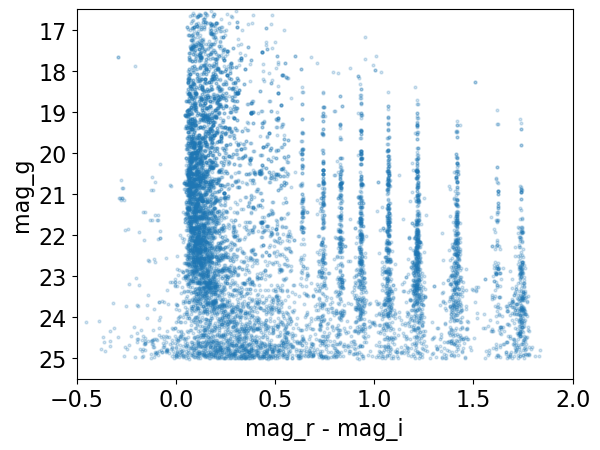

In [9]:
plt.plot(fluxToMag(table['r_calibFlux'].values) - fluxToMag(table['i_calibFlux'].values),
         fluxToMag(table['g_calibFlux'].values),
         'o', ms=2, alpha=0.2)

plt.xlabel('mag_r - mag_i', fontsize=16)
plt.ylabel('mag_g', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim([-0.5, 2.0])
plt.ylim([25.5, 16.5])

plt.show()

**Note**: The "quantisation" of the colours is a consequence of the simulated data that went into producing DP0.

## Aside: Known sources in DP0

The DP0 dataset is based on a simulation of the sky, the "images" of which have been passed through the LSST Data Release Production pipelines to produces the measurements that we extract from the tables. Since it's based on a simulation, we know everything that went into it (i.e., the "truth"), so we know where each object should be, and what type of object it really is.

This means that with DP0, we can use this truth information to hone-in on an object that we know will have a meaningful lightcurve - whereby I mean something whose flux changes due to a physical change in the object, not just random noise. In what follows, this is an RR-Lyrae star.

## Query the object table again to get the objectId of our object

In [10]:
known_rrl = "62.1479031, -35.799138"

In the following, I don't have to return the ra and dec, but it's good as a sanity check...

In [11]:
my_adql_query = (
    "SELECT TOP 10 "
    "coord_ra, coord_dec, objectId "
    "FROM dp02_dc2_catalogs.Object "
    "WHERE "
    "CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS',"+known_rrl + ", 0.001)) = 1 "
    "AND detect_isPrimary = 1" #This ensures we ignore sources deblended from the primary detection. 
)
results = service.search(my_adql_query)
obj = results.to_table()
obj

coord_ra,coord_dec,objectId
deg,deg,
float64,float64,int64
62.1479018,-35.7991382,1651589610221899038


In [12]:
objid = obj[0]['objectId']

## Now use that objectId to query the table containing forced source measurements...

In [13]:
my_adql_query = (
    "SELECT ccdVisitId, band, "
    "objectId, coord_ra, coord_dec, "
    "psfFlux, psfFluxErr "
    "FROM dp02_dc2_catalogs.ForcedSource "
    "WHERE objectId = "+str(objid) + " "
    "AND band = 'r'" # For simplicity, only return r-band measurements
)
results = service.search(my_adql_query)
srcs = results.to_table()
srcs

ccdVisitId,band,objectId,coord_ra,coord_dec,psfFlux,psfFluxErr
,,,deg,deg,nJy,nJy
int64,object,int64,float64,float64,float64,float64
414861046,r,1651589610221899038,62.1479018,-35.7991382,131851.1538881,386.7600372
718818112,r,1651589610221899038,62.1479018,-35.7991382,170332.2843202,434.7878455
943324129,r,1651589610221899038,62.1479018,-35.7991382,146328.0393507,421.0905817
943325140,r,1651589610221899038,62.1479018,-35.7991382,147724.9138055,424.9277484
414892047,r,1651589610221899038,62.1479018,-35.7991382,129683.0533897,381.2756228
721835057,r,1651589610221899038,62.1479018,-35.7991382,176142.8397585,447.0436574
753606017,r,1651589610221899038,62.1479018,-35.7991382,141989.9975897,417.7439037
718857011,r,1651589610221899038,62.1479018,-35.7991382,165033.4966435,424.895895


## If we want to make a lightcurve, we need temporal information...

There isn't any time-of-observation information in the ForcedSource table, so we need to look elsewhere for that. The dp02_dc2_catalogs.CcdVisit table does contain such information, and it also contains the ccdVisitId number that we SELECTed from the ForcedSource table.

As such, if we JOIN the ForcedSource and CcdVisit tables on their respective ccdVisitId columns, then we can get source information from the former and time-of-observation data from the latter...

In [14]:
my_adql_query = (
    "SELECT src.ccdVisitId, src.band, "
    "src.objectId, src.coord_ra, src.coord_dec, "
    "src.psfFlux, src.psfFluxErr, "
    "ccd.expMidptMJD " # This is the time information we want
    "FROM dp02_dc2_catalogs.ForcedSource as src "
    "JOIN dp02_dc2_catalogs.CcdVisit as ccd "
    "ON ccd.ccdVisitId = src.ccdVisitId "
    "WHERE src.objectId = "+str(objid) + " "
    "AND src.band = 'r'"
)
results = service.search(my_adql_query)
srcs = results.to_table()
srcs

ccdVisitId,band,objectId,coord_ra,coord_dec,psfFlux,psfFluxErr,expMidptMJD
,,,deg,deg,nJy,nJy,d
int64,object,int64,float64,float64,float64,float64,float64
414861046,r,1651589610221899038,62.1479018,-35.7991382,131851.1538881,386.7600372,60166.3331702
718818112,r,1651589610221899038,62.1479018,-35.7991382,170332.2843202,434.7878455,60643.0669522
943324129,r,1651589610221899038,62.1479018,-35.7991382,146328.0393507,421.0905817,60961.2457292
943325140,r,1651589610221899038,62.1479018,-35.7991382,147724.9138055,424.9277484,60961.2461782
414892047,r,1651589610221899038,62.1479018,-35.7991382,129683.0533897,381.2756228,60166.3471312
721835057,r,1651589610221899038,62.1479018,-35.7991382,176142.8397585,447.0436574,60647.1295272
753606017,r,1651589610221899038,62.1479018,-35.7991382,141989.9975897,417.7439037,60693.1292282
718857011,r,1651589610221899038,62.1479018,-35.7991382,165033.4966435,424.895895,60643.0845602


## Create a plot of r-band magnitude vs. time (aka the r-band lightcurve)

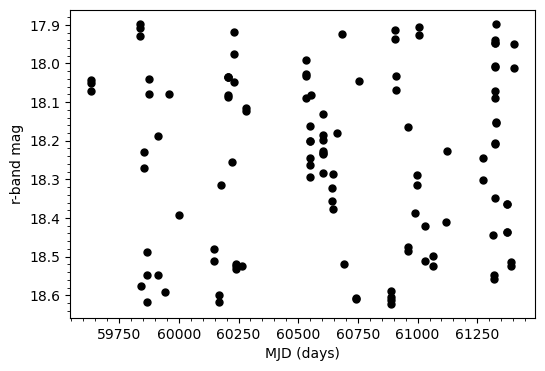

In [15]:
fig = plt.figure(figsize=(6, 4))
plt.plot(srcs['expMidptMJD'], fluxToMag(srcs['psfFlux']), 'k.', ms=10)
plt.minorticks_on()
plt.xlabel('MJD (days)')
plt.ylabel('r-band mag')
plt.gca().invert_yaxis()
plt.show()

## Aside: Making a phased lightcure plot

We've now done everything we need to with regard to querying tables for this part of the Intro To RSP session, so what follows is just something a little extra for completeness... 

There's clearly some periodicity in the above lightcurve, so a nicer thing to make is a phased lightcure, whereby the time axis is "looped round" after each full cycle.

I happen to know that the period of this particular simulated RR-Lyrae is 0.50953 days*, which I can use with the existing temporal information to create a phased lightcurve...

*see DP0 Tutorial Notebook 7b for how this was calculated

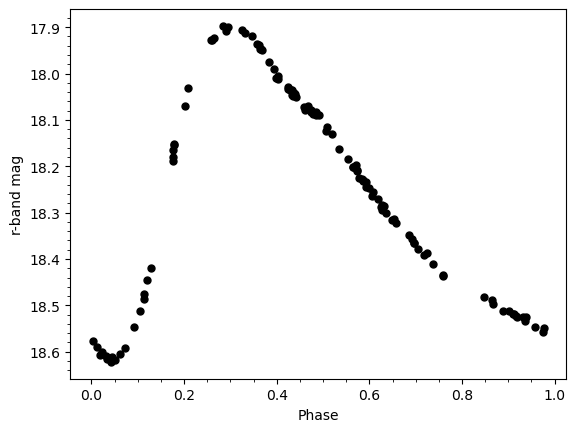

In [16]:
period = 0.50953
phase = np.mod(srcs['expMidptMJD'] / period, 1.0)

plt.plot(phase, fluxToMag(srcs['psfFlux']), 'k.', ms=10)
plt.minorticks_on()
plt.xlabel('Phase')
plt.ylabel('r-band mag')
plt.gca().invert_yaxis()
plt.show()

## Aside: How to retrieve magnitudes directly from a query...

In the above notebook, I defined a function `fluxToMag()` to convert fluxes in nJy to magnitudes. However, as I mentioned above, it's possible to get an ADQL query to return magnitudes directly (provided the necessary plugins have been installed which, in the case of the RSP, they have).

To return mags instead of fluxes, simply wrap the flux column name in the SELECT block with `scisql_nanojanskyToAbMag()`. If you want it to also return error estimates on those magnitudes, you can use `scisql_nanojanskyToAbMagSigma()`, but you need to include **both** the flux and the flux error within the brackets (this is a consequence of how errors-on-magnitudes are calculated).

Using this, my object table query - which now also returns errors on the g-band mag to demonstrate this feature - becomes...

In [17]:
my_adql_query = (
    "SELECT TOP 200 "
    "coord_ra, coord_dec, "
    "scisql_nanojanskyToAbMag(g_calibFlux) as gMag, "
    "scisql_nanojanskyToAbMagSigma(g_calibFlux, g_calibFluxErr) as gMagErr, "
    "scisql_nanojanskyToAbMag(r_calibFlux) as rMag, "
    "scisql_nanojanskyToAbMag(i_calibFlux) as iMag "
    "FROM dp02_dc2_catalogs.Object "
    "WHERE "
    "CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62.0, -37.0, 1.0)) = 1 "
    "AND g_calibFlux > 360 AND r_calibFlux > 360 AND i_calibFlux > 360"
    "AND g_extendedness = 0 "
)
results = service.search(my_adql_query)
table = results.to_table().to_pandas()
table

,coord_ra,coord_dec,gMag,gMagErr,rMag,iMag
0,61.124486,-37.176111,21.005768,0.002744,20.751314,20.670558
1,61.016083,-37.163773,24.589829,0.063269,24.676918,24.661697
2,61.137792,-37.163859,18.202225,0.000333,17.494067,17.231457
3,61.106476,-37.164506,24.850789,0.086852,24.421743,24.308621
4,61.106353,-37.162731,20.663994,0.002009,19.527048,18.110453
...,...,...,...,...,...,...
195,60.929540,-37.385671,21.058834,0.002853,20.647937,20.498618
196,60.908013,-37.394025,20.468882,0.001669,19.961645,19.725416
197,61.133042,-37.392894,20.343463,0.001505,20.061355,19.962039
198,60.901992,-37.393764,23.009417,0.015787,21.834798,20.762874
